In [1]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
points_recep = sc.read.json('../datos/points-recep.jsonlines').rdd

## Utils

In [4]:
def remove_no_receptions(l):
    return list(filter(lambda e: e > 0, l))



### Promedio del promedio y del stdev de las potencias recibidas por emision

#### (3) ¿En cada antena, por que valores de potencia suelen moverse los puntos que le mandan señales?

In [ ]:
##prueba

In [9]:
train_points = sc.read.json('../datos/points-recep-with-zeros.jsonlines').rdd

In [56]:
def split_by_angle(emissions):
    size = len(emissions)
    return [emissions[0:6],emissions[6:12],emissions[12:18],emissions[18:size]]

def remove_zeros(emissions):
    return [e for e in emissions if e>0]

def remove_if_few_recep(emissions):
    return [e for e in emissions if len(e) > 1]



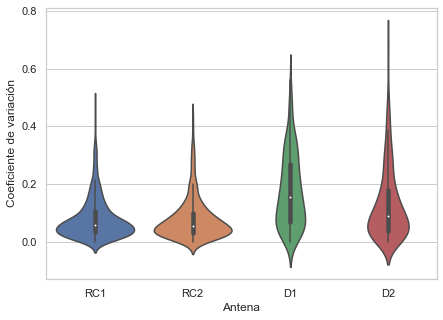

In [71]:
cv_by_antenna = []
for i in range(4):
     cv_by_antenna.append(
        train_points
        .map(lambda x: x[f'recep_{i}'])
        .map(split_by_angle)
        .map(lambda x: list(map(remove_zeros,x)))
        .map(remove_if_few_recep)
        .flatMap(lambda x: x)
        .map(lambda x: np.std(x) / np.mean(x))
        .collect()
    )

data = pd.concat([
    pd.DataFrame({'Coeficiente de variación': cv_by_antenna[0], 'Antena': nombre_antenas[0]}),
    pd.DataFrame({'Coeficiente de variación': cv_by_antenna[1], 'Antena': nombre_antenas[1]}),
    pd.DataFrame({'Coeficiente de variación': cv_by_antenna[2], 'Antena': nombre_antenas[2]}),
    pd.DataFrame({'Coeficiente de variación': cv_by_antenna[3], 'Antena': nombre_antenas[3]}),
])

fig, ax = plt.subplots(1,1, figsize=(7,5))
sns.set(style="whitegrid")

sns.violinplot(y='Coeficiente de variación',x='Antena',data=data,ax=ax)

fig.savefig('ViolinDelCVdePotenciasPorAntena.png')

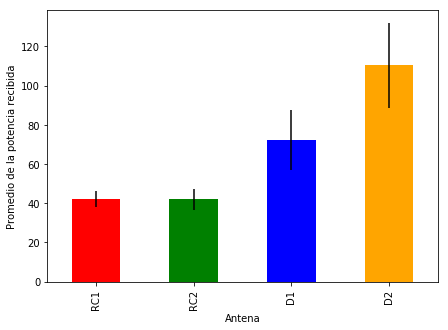

In [213]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    mean = recepciones.map(lambda x: np.mean(x)).mean()
    stdev = recepciones.map(lambda x: np.std(x)).mean()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})
    
data = pd.DataFrame(same_emisions_mean_and_std)
data.plot.bar(x='antenna', y='mean', yerr='stdev', legend=False, color=['red','green','blue','orange'], ax=ax)
ax.set_ylabel('Promedio de la potencia recibida')
ax.set_xlabel('Antena')
ax.set_xticklabels(nombre_antenas)

fig.savefig('PromedioDelPromediodePotenciasPorAntena.png')

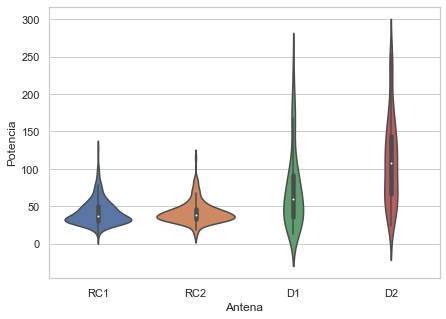

In [76]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
sns.set(style="whitegrid")

recep_by_antenna = {}
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    recep_by_antenna[f'antena_{i}'] = recepciones.map(lambda x: np.mean(x)).collect()
    
data = pd.concat([
    pd.DataFrame({'Potencia': recep_by_antenna['antena_0'], 'Antena': nombre_antenas[0]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_1'], 'Antena': nombre_antenas[1]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_2'], 'Antena': nombre_antenas[2]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_3'], 'Antena': nombre_antenas[3]}),
])
sns.violinplot(y='Potencia',x='Antena',data=data,ax=ax)

fig.savefig('ViolinDelPromediodePotenciasPorAntena.png')

### Promedio y stdev de las potencias recibidas por antena

#### (3.5) ¿Todas las antenas reciben señales con la misma intensidad?

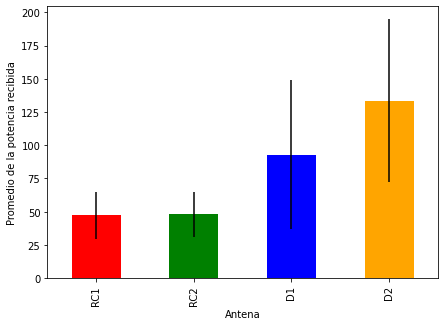

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

same_emisions_mean_and_std = []
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    mean = recepciones.flatMap(lambda x: x).mean()
    stdev = recepciones.flatMap(lambda x: x).stdev()
    same_emisions_mean_and_std.append({'antenna': i, 'mean': mean, 'stdev': stdev})

data = pd.DataFrame(same_emisions_mean_and_std)
data.plot.bar(x='antenna', y='mean', yerr='stdev', legend=False, color=['red','green','blue','orange'],ax=ax)
ax.set_ylabel('Promedio de la potencia recibida')
ax.set_xlabel('Antena')
ax.set_xticklabels(nombre_antenas)

fig.savefig('PromedioPotenciaPorAntena.png')

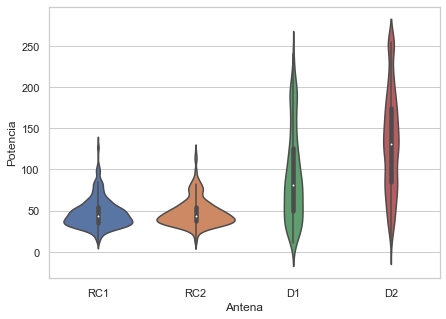

In [77]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

recep_by_antenna = {}
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    recepciones = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: x[recep_field])
    recep_by_antenna[f'antena_{i}'] = recepciones.flatMap(lambda x: x).collect()
    
data = pd.concat([
    pd.DataFrame({'Potencia': recep_by_antenna['antena_0'], 'Antena': nombre_antenas[0]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_1'], 'Antena': nombre_antenas[1]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_2'], 'Antena': nombre_antenas[2]}),
    pd.DataFrame({'Potencia': recep_by_antenna['antena_3'], 'Antena': nombre_antenas[3]}),
])
sns.violinplot(y='Potencia',x='Antena',data=data,ax=ax)

fig.savefig('ViolinPotenciaPorAntena.png')

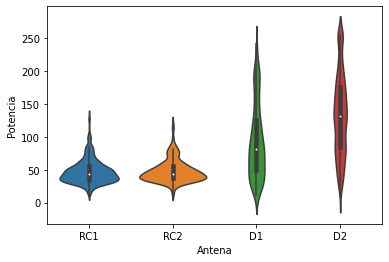

### Variación de la potencia de las señales en funcion de la cantidad de señales recibidas

#### (6) ¿Es cierto que mientras más potencia tenga una señal, es mas probable que llegue a la antena?

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


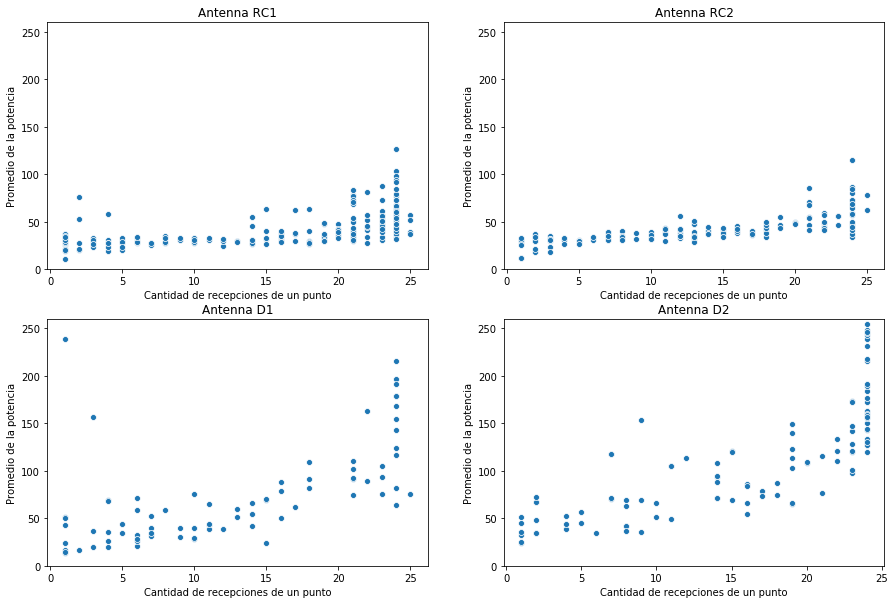

In [187]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    ax = axs.flatten()[i]
    recep_field = 'recep_{}'.format(i)
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field]))})
    p_pd = p.toDF().toPandas()

    sns.scatterplot(x='n',y='mean',data=p_pd, ax=ax)
    ax.set_title('Antenna {}'.format(nombre_antenas[i]))
    ax.set_xlabel('Cantidad de recepciones de un punto')
    ax.set_ylabel('Promedio de la potencia')
    ax.set_ylim(0,260)


fig.savefig('VariacionPotenciaSeñalesEnFuncionCantidadRecibidas.png')

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


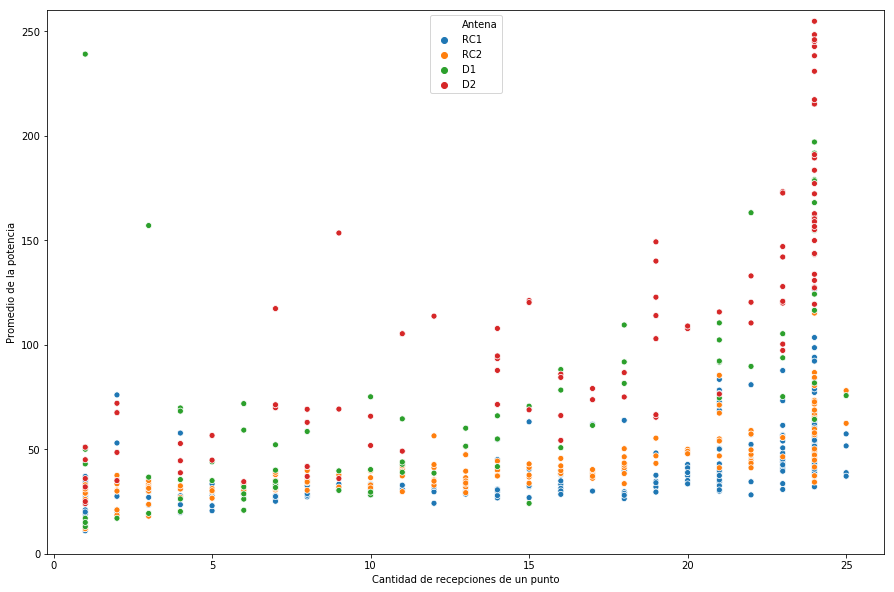

In [188]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
p = sc.sparkContext.emptyRDD()
for i in range(4):
    recep_field = 'recep_{}'.format(i)
    emissionsPower = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'n': len(x[recep_field]),'mean': float(np.mean(x[recep_field])), 'Antena': nombre_antenas[i]})
    p = p.union(emissionsPower)

p_pd = p.toDF().toPandas()

sns.scatterplot(x='n',y='mean',hue='Antena',data=p_pd, ax=ax)
ax.set_xlabel('Cantidad de recepciones de un punto')
ax.set_ylabel('Promedio de la potencia')
ax.set_ylim(0,260)
ax.legend(loc="upper center")

fig.savefig('VariacionPotenciaSeñalesEnFuncionCantidadRecibidasJunto.png')

### Mapa con colores con la intensidad de la señal recibida en cada antena por los puntos

#### (7) ¿Como es la distribucion espacial de las potencias?

In [5]:
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


In [6]:
def calculate_avg_power(grouped_row, antena):
    signals = list(map(lambda x: x['recep_{}'.format(antena)], list(grouped_row[1])))
    signals_pd = pd.DataFrame([s for emision in signals for s in emision ])
    n = len(signals_pd)
    if n > 0:
        mean = float(signals_pd.mean()[0])
        stdev = float(signals_pd.std()[0])
    else:
        mean = 0
        stdev = 0
    return {
        'Punto': grouped_row[0],
        'mean': mean,
        'stdev': stdev,
        'relative_std': stdev/float(mean) if mean > 0 else 0,
        'n': n,
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


In [7]:
global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


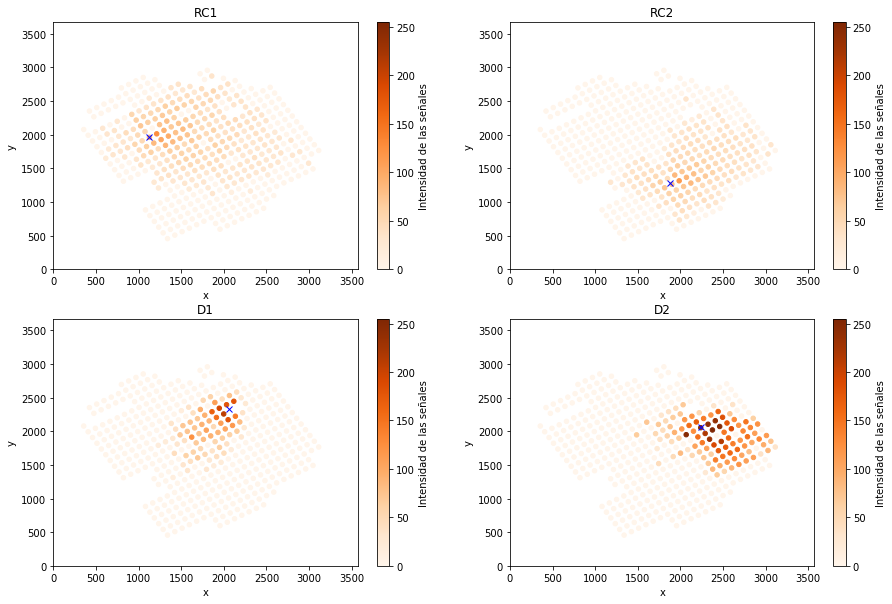

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

for antena in range(4):
    
    points_sig = points_recep.groupBy(lambda x:x['Punto']).map(lambda x: calculate_avg_power(x,antena)).map(normalize_positions)#.filter(lambda x: x['mean'] != 0)
    data = pd.DataFrame(points_sig.collect()).rename(columns={'mean': 'Intensidad de las señales'})
    ax = axs.flatten()[antena]
    data.plot.scatter(x='x', y='y',c='Intensidad de las señales',cmap='Oranges', vmin=0, vmax=255, ax=ax)#,s=data['stdev']+1)

    pos_antena = posicion_antenas[antena]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
    ax.set_ylim([0,y_f-y_0])
    ax.set_xlim([0,x_f-x_0])
    ax.set_title(nombre_antenas[antena])

plt.savefig('MapaColorIntensidadSeñalRecibidaPorAntena.png')

### Mapa con la cantidad de antenas usadas por punto

#### (8) ¿Cuantas antenas utiliza cada punto?

In [11]:
def calculate_amount_antennas_recep(grouped_row):
    signals = list(map(lambda x: [len(x['recep_{}'.format(i)])>0 for i in range(4)], list(grouped_row[1])))

    has_recep_by_antenna = np.array([False, False, False, False])
    for l in signals:
        has_recep_by_antenna = has_recep_by_antenna | np.array(l)

    return {
        'Punto': grouped_row[0],
        'cant': sum(has_recep_by_antenna),
        'x': list(grouped_row[1])[0]['x'],
        'y': list(grouped_row[1])[0]['y']
    }


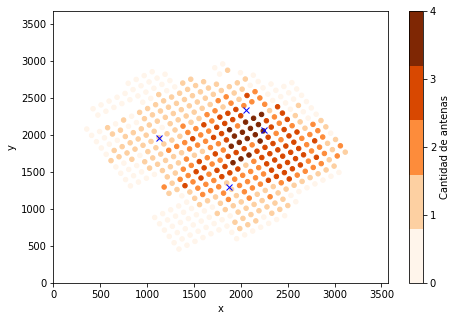

In [9]:
from matplotlib.colors import ListedColormap
cMap = ListedColormap(list(reversed(
    [
        [0.4980392156862745, 0.15294117647058825, 0.01568627450980392, 1.0],
        [0.8462745098039215, 0.28069204152249133, 0.004106113033448673, 1.0],
        [0.9914186851211073, 0.550726643598616, 0.23277201076509035, 1.0],
        [0.9921568627450981, 0.814640522875817, 0.6336024605920799, 1.0],
        [1.0, 0.9607843137254902, 0.9215686274509803, 1.0]
    ]
)))

fig = plt.figure(figsize=(7.5,5))
points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
data = pd.DataFrame(points_sig.collect()).rename(columns={'cant': 'Cantidad de puntos'})
#data.plot.scatter(x='x', y='y',c='Cantidad de puntos',cmap=cMap,ax=ax)
plt.scatter(x='x', y='y',c='Cantidad de puntos',cmap=cMap, s=20,data=data)
ax=plt.gca()
for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
ax.set_ylim(0,y_f-y_0)
ax.set_xlim(0,x_f-x_0)
ax.set_xlabel('x')
ax.set_ylabel('y')

cb = plt.colorbar()
loc = np.arange(0,5,1)
cb.set_ticks(loc)
cb.set_ticklabels(['0','1','2','3','4'])
cb.set_label('Cantidad de antenas')

fig.savefig('MapaCantidadAntenasUsadasPorPunto.png')

In [164]:
plt.rcParams['lines.markersize']

6.0

### Cantidad de puntos que usan _x_ cantidad de antenas

#### (9) ¿Cuantos puntos usan 1 antena? ¿Y 2 antenas?

In [173]:
cant_recep = points_sig.groupBy(lambda x: x['cant']).map(lambda x: {'antennas': x[0],'cant_points': len(x[1])})

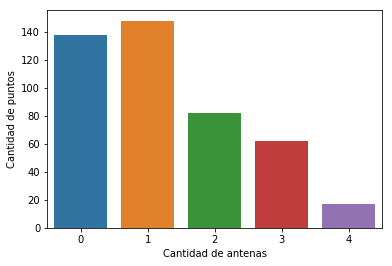

In [176]:
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(1,1,1)


sns.barplot(x='antennas', y='cant_points', data=pd.DataFrame(cant_recep.collect()), linewidth=50, ax=ax)
ax.set_ylabel('Cantidad de puntos')
ax.set_xlabel('Cantidad de antenas')

fig.savefig('CantidadPuntosXAntena.png')

### Relacion distancia-intensidad

#### (10) ¿Es cierto que al aumentar la distancia disminuye la potencia?

/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "
/Users/alew/py3/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


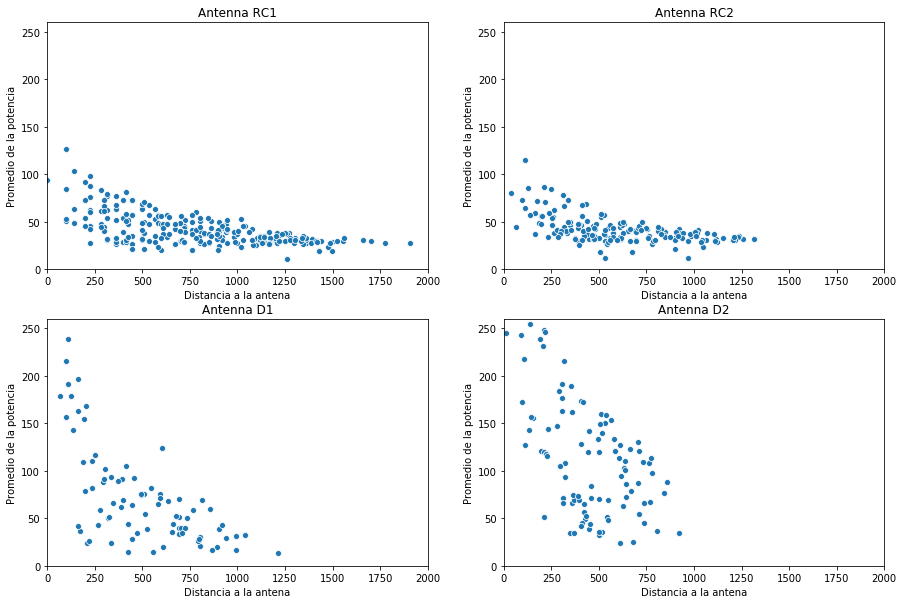

In [186]:
import math


def calculate_distance(x0,y0,x1,y1):
    return math.sqrt((x0-x1)**2+(y0-y1)**2)


fig, axs = plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    ax = axs.flatten()[i]
    recep_field = 'recep_{}'.format(i)
    pos_antena = posicion_antenas[i]
    p = points_recep.filter(lambda x: len(x[recep_field]) > 0).map(lambda x: {'Punto': x['Punto'],'distance': calculate_distance(pos_antena[0], pos_antena[1], x['x'], x['y']),'mean': float(np.mean(x[recep_field]))})
    p_pd = p.toDF().toPandas()

    sns.scatterplot(x='distance',y='mean',data=p_pd, ax=ax)
    ax.set_title('Antenna {}'.format(nombre_antenas[i]))
    ax.set_xlabel('Distancia a la antena')
    ax.set_ylabel('Promedio de la potencia')
    ax.set_ylim(0,260)
    ax.set_xlim(0,2000)
    
    
fig.savefig('RelacionDistanciaIntensidad.png')

In [8]:
import math


def rotate(xy, theta):
    cos_theta, sin_theta = math.cos(theta), math.sin(theta)

    return (
        xy[0] * cos_theta - xy[1] * sin_theta,
        xy[0] * sin_theta + xy[1] * cos_theta
    )


def translate(xy, offset):
    return xy[0] + offset[0], xy[1] + offset[1]



area = []
w = 1600/3
h=1400/3
degrees = 32
init_offset = (1400, 730)
for i in range(3):
    for j in range(3):

        points = [
            (0, 0),
            (0, h),
            (w, h),
            (w, 0)
        ]
        x_offset, y_offset = 0,0
        if i+j > 0:
            x_offset = j*(area[0][1][0]-area[0][0][0])+i*(area[0][3][0]-area[0][0][0])
            y_offset = j*(area[0][1][1]-area[0][0][1])+i*(area[0][3][1]-area[0][0][1])
        offset = (init_offset[0]+x_offset, init_offset[1]+y_offset)
        theta = math.radians(degrees)

        # Apply rotation, then translation to each point
        area.append([translate(rotate(xy, theta), offset) for xy in points])


In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patches = []
for a in area:
    polygon = Polygon(a, True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.gnuplot, alpha=0.4)
colors = [(i+1)*15 for i in range(9)]
random.shuffle(colors)

p.set_array(np.array(colors))


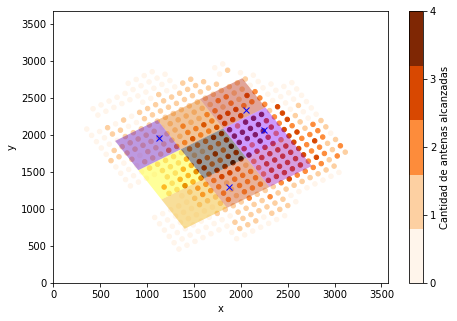

In [30]:
from matplotlib.colors import ListedColormap
cMap = ListedColormap(list(reversed(
    [
        [0.4980392156862745, 0.15294117647058825, 0.01568627450980392, 1.0],
        [0.8462745098039215, 0.28069204152249133, 0.004106113033448673, 1.0],
        [0.9914186851211073, 0.550726643598616, 0.23277201076509035, 1.0],
        [0.9921568627450981, 0.814640522875817, 0.6336024605920799, 1.0],
        [1.0, 0.9607843137254902, 0.9215686274509803, 1.0]
    ]
)))

fig = plt.figure(figsize=(7.5,5))
points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
data = pd.DataFrame(points_sig.collect()).rename(columns={'cant': 'Cantidad de puntos'})

plt.scatter(x='x', y='y',c='Cantidad de puntos',cmap=cMap, s=20,data=data)
ax=plt.gca()
for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "xb")
    
ax.set_ylim(0,y_f-y_0)
ax.set_xlim(0,x_f-x_0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.add_collection(p)

cb = plt.colorbar()
loc = np.arange(0,5,1)
cb.set_ticks(loc)
cb.set_ticklabels(['0','1','2','3','4'])
cb.set_label('Cantidad de antenas alcanzadas')

fig.savefig('RegionesRegularesMapa22.png')

In [218]:
from ..utils.emissions_normalizer import EmissionsNormalizer
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd


normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

ValueError: attempted relative import beyond top-level package

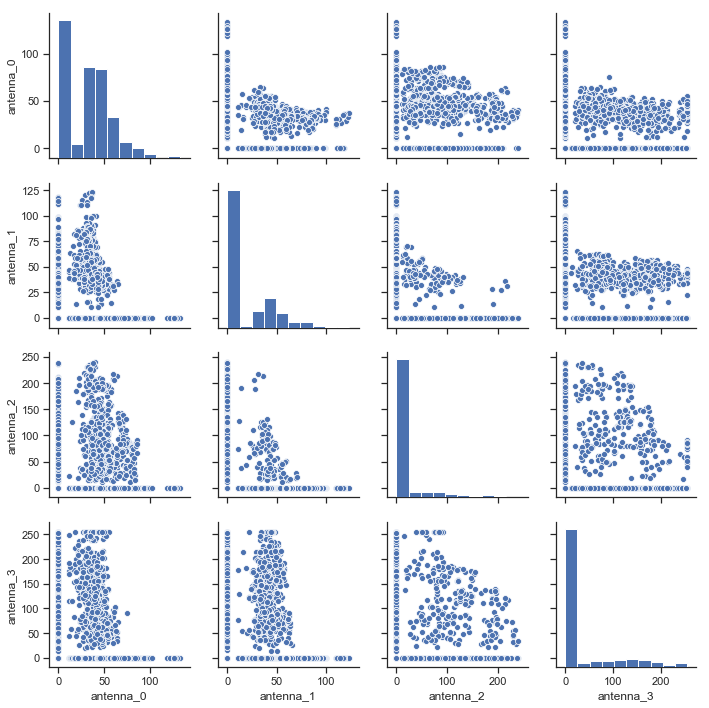

In [26]:
import seaborn as sns
sns.set(style="ticks")

f = sns.pairplot(regre_data)
f.savefig('antennas_scatter_matrix.png')

#### Mapa

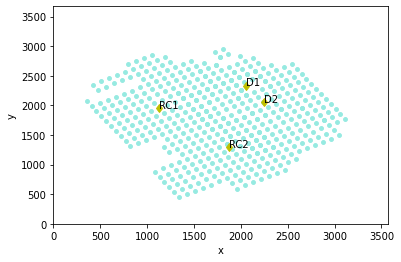

In [21]:
fig, ax = plt.subplots()



ax.set_ylim(0,y_f-y_0)
ax.set_xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
ax.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=15, label = None)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        ax.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 


ax.set_xlabel('x')
ax.set_ylabel('y')

plt.savefig('MapaAntenasYCalibracion.png')